In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import math
import time

In [2]:
class Gaussian:
    def __init__(self, width, amplitude, x0):
        self.width = width
        self.amplitude = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        A = self.amplitude
        x0 = self.x0
        sigma = self.width
        return A*np.exp(-((x[0]-x0[0])**2 + (x[1]-x0[1])**2)/sigma**2)

In [3]:
class propagate:
    def __init__(self, Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.Lz = Lz
        self.Nz = Nz
        self.k = k
        self.K = K
        self.non_f = non_f
        
        #We can reduce the code by using step parameter in linspace
        
        self.dz = Lz/Nz
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.matrix = np.zeros([Nz, 2*Nx, 2*Ny])
        
        kx = 2*np.pi*np.fft.fftfreq(2*Nx, d=self.dx)
        ky = 2*np.pi*np.fft.fftfreq(2*Ny, d=self.dy)
        self.kx = kx
        self.ky = ky
        kxy2 = np.zeros([2*Nx, 2*Ny])
        
        for i in range(2*Nx):
            for j in range(2*Ny):
                kxy2[i][j] = kx[i]**2 + ky[j]**2
        self.kxy2 = kxy2
                
        self.x = np.linspace(-Lx, Lx, 2*Nx)
        self.y = np.linspace(-Ly, Ly, 2*Ny)
        E = np.zeros([2*Nx, 2*Ny])
        
        #intialisation
        for i in range(2*Nx):
            for j in range(2*Ny):
                x0 =(2*Lx)/(2*Nx-1)*i -Lx
                x1 =(2*Ly)/(2*Ny-1)*j -Ly
                #x0 =(2*Lx)/(2*Nx-1)*i
                #x1 =(2*Ly)/(2*Ny-1)*j
                E[i][j] = init_f([x0, x1])
                
        #Pertubation
        #const = np.max(E)
        #print(const)
        #for i in range(2*Nx):
        #    for j in range(2*Ny):
        #        E[i][j] += const*1.5e-1*np.random.uniform(-1,1)
        
        self.E = E
        self.matrix[0,:,:] = E
        
    def evolution(self):
        list_z =[]
        list_z1 = []
        E = self.E*(1+1j*0)
        list_z.append(np.abs(E)**2)
        list_z1.append(E)
        
        for l in range(Nz-1):
            '''
            #solve for non-linear
            c = np.exp(1j*self.non_f(E)*self.dz)*E
            c = np.fft.fft2(c)
            c *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(c)
            
            '''
            #Linear
            Ek = np.fft.fft2(E)
            Ek *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(Ek)
            #print(np.abs(E)/list_z[-1])
        
            #Non-linear
            #print(non_f(E)*self.dz/E)
            #if l == 0: E += non_f(E)*self.dz
            #else: E += (3/2)*non_f(list_z1[-1])*self.dz - (1/2)*non_f(list_z1[-2])*self.dz
            E += non_f(E)*self.dz
            
            #Putting into list
            if (l % 100 == 0):
                list_z.append(np.abs(E)**2)
                list_z1.append(E)
            if (l % 1000 == 0):
                print(l/Nz*100)
        
        list_z = np.asarray(list_z)
        list_z1 = np.asarray(list_z1)
        self.matrix = list_z
        self.matrix2 = list_z1

In [4]:
cross = 5.1*1e-24
light = 3*1e8
lamb = 775*1e-9
omega = 2*np.pi*light/lamb
tau = 3.5*1e-13
beta = 6.5*1e-104
hbar = 6.62*1e-34/np.pi
tp = 200*1e-15
f = 1/2
#f = 0
n2 = 5.57*1e-23
k = 2*np.pi/lamb
K = 7
w0 = 0.7*1e-3

const0 = -2j/(k*w0**2)
const1 = -cross/2*(1 + 1j*omega*tau)*beta/(K*hbar*omega)*tp*(np.pi/8*K)**(1/2)
const2 = -beta/2
const3 = 1j*omega/light*(1-f)*n2

#const1 = 0
#const2 = 0
#const3 = 0

#normaliser
const1 = const1*(10**8)**(2*K)
const2 = const2*(10**8)**(2*K-2)
const3 = const3*(10**8)**2

def non_f(E):
    return const1*E*np.abs(E)**(2*K) + const2*E*np.abs(E)**(2*K - 2) + const3*E*np.abs(E)**2


In [5]:
print(const0, const1, const2, const3)

(-0-0.5034493097804854j) (-1.5319934845080613e-10-1.30414050324951e-07j) -3.25e-08 2.2578930426445347j


In [6]:
Pcr = 1.7*1e9
p = 35
Pin = p*Pcr
AMP = (2*Pin/(math.pi*w0**2))**(1/2)
x0 = [0., 0.]



#normaliser
AMP = AMP*1e-8
#AMP = 5
#print(AMP)
gauss = Gaussian(w0, AMP, x0)

Lx = 3*1e-3
Nx = 128
Ly = 3*1e-3
Ny = 128
dz = 2./12000.
Lz = 10
Nz = int(Lz/dz)

init_f = gauss

laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
t1 = time.time()
laser.evolution()
t2 = time.time()
print("Running time: ",t2-t1)

#for i in range(25):
#    fig, ax = plt.subplots()
#    mesh = ax.pcolormesh(Pro.x, Pro.y, Pro.matrix[i*10])
#    ax.set_xlabel('x')
#    ax.set_ylabel('y')
#    plt.colorbar(mesh, ax=ax)
#    fig.show()



0.0
1.6666666666666667
3.3333333333333335
5.0
6.666666666666667
8.333333333333332
10.0
11.666666666666666
13.333333333333334
15.0
16.666666666666664
18.333333333333332
20.0
21.666666666666668
23.333333333333332
25.0
26.666666666666668
28.333333333333332
30.0
31.666666666666664
33.33333333333333
35.0
36.666666666666664
38.333333333333336
40.0
41.66666666666667
43.333333333333336
45.0
46.666666666666664
48.333333333333336
50.0
51.66666666666667
53.333333333333336
55.00000000000001
56.666666666666664
58.333333333333336
60.0
61.66666666666667
63.33333333333333
65.0
66.66666666666666
68.33333333333333
70.0
71.66666666666667
73.33333333333333
75.0
76.66666666666667
78.33333333333333
80.0
81.66666666666667
83.33333333333334
85.0
86.66666666666667
88.33333333333333
90.0
91.66666666666666
93.33333333333333
95.0
96.66666666666667
98.33333333333333
Running time:  208.30714225769043


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


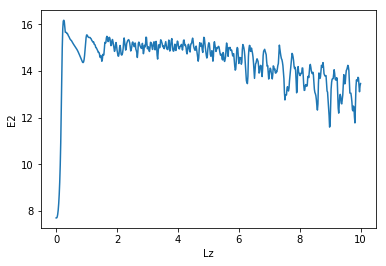

In [7]:
listed_normed = []
num_point = laser.matrix.shape[0]
for i in range(num_point):
    listed_normed.append(np.max(laser.matrix[i].real))
screen = np.linspace(0, Lz, laser.matrix.shape[0])
listed_normed = np.asarray(listed_normed)

fig, ax = plt.subplots()
ax.plot(screen, listed_normed)
ax.set_xlabel('Lz')
ax.set_ylabel('E2')
ax.legend()
#plt.xlim(0.007, 0.009)
fig.show()

In [8]:
print(laser.matrix.shape)

(601, 128, 128)


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


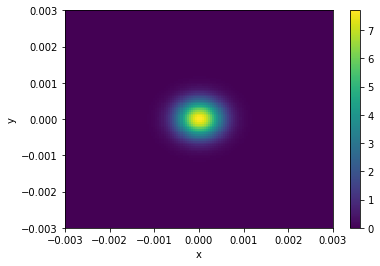

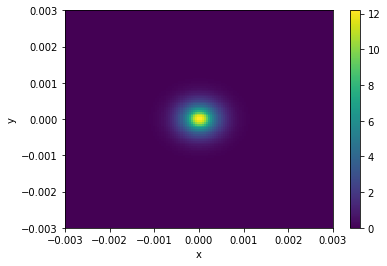

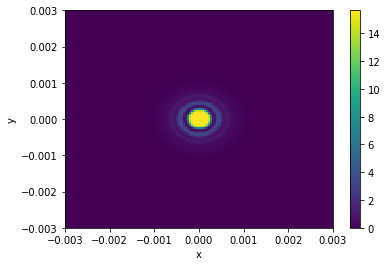

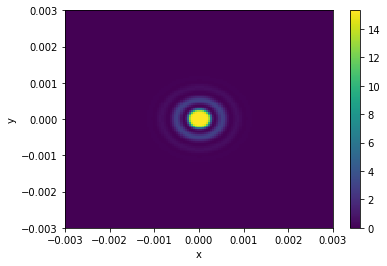

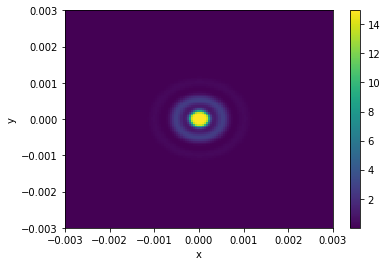

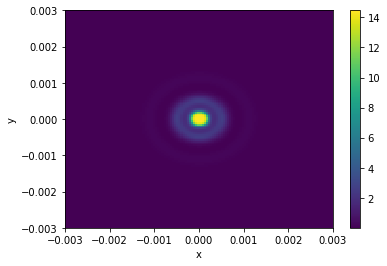

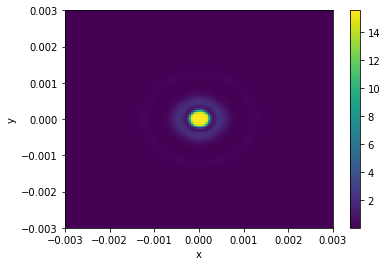

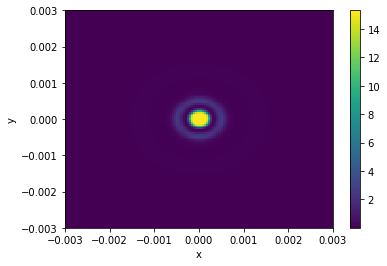

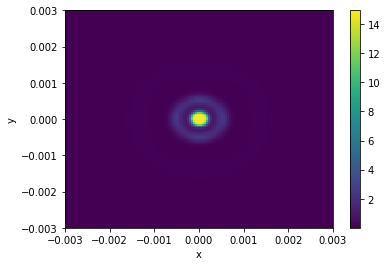

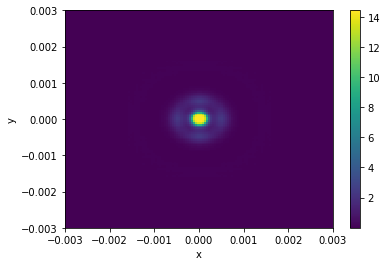

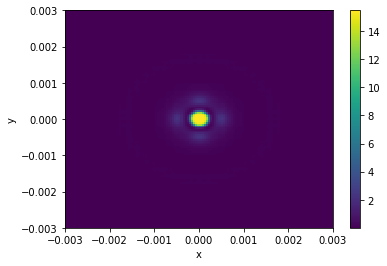

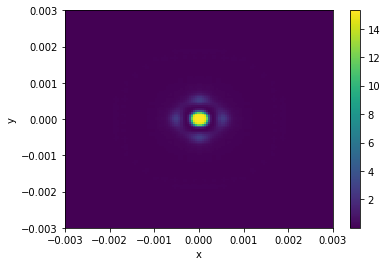

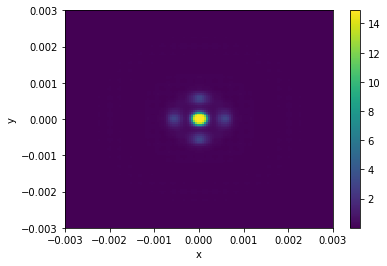

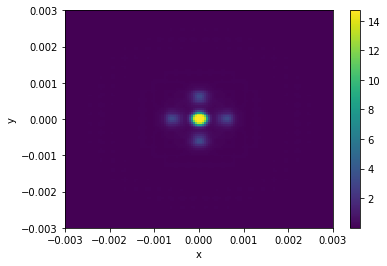

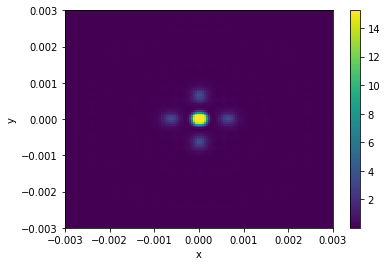

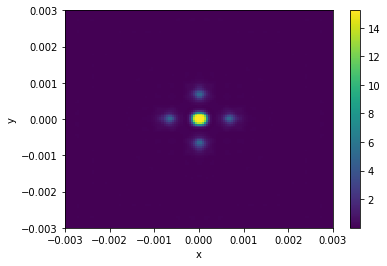

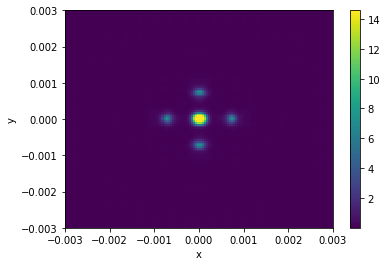

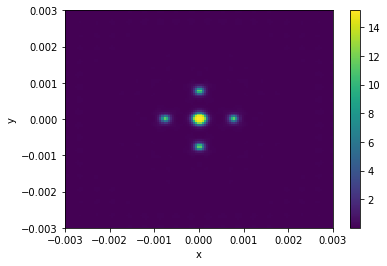

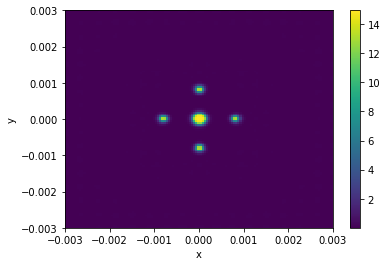

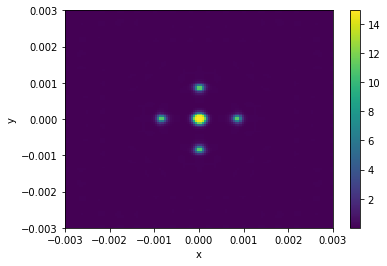

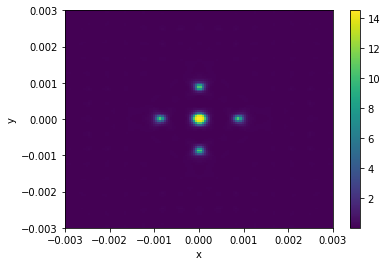

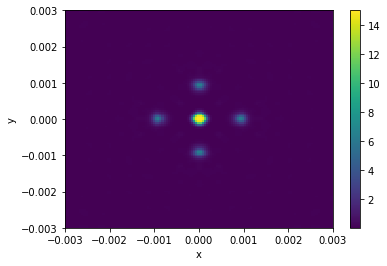

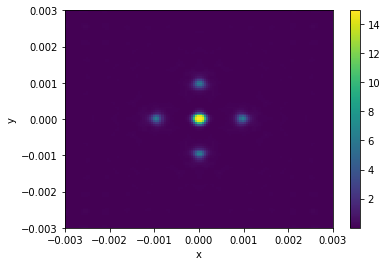

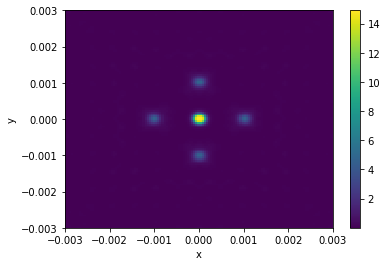

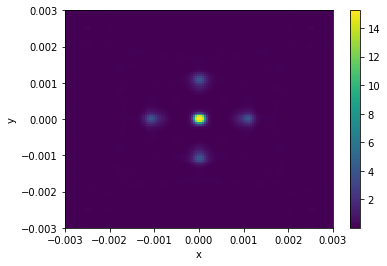

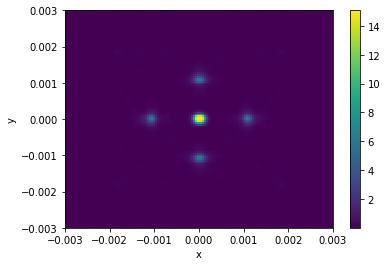

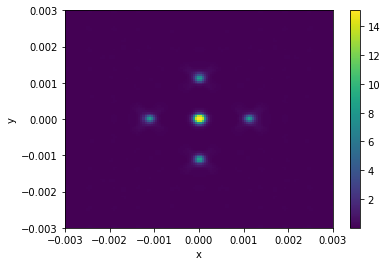

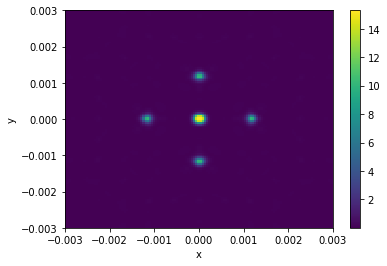

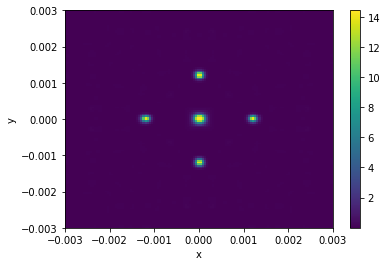

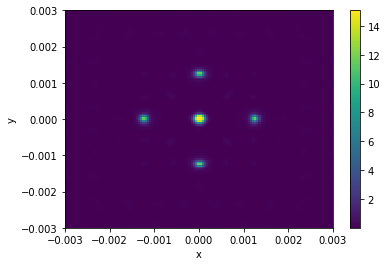

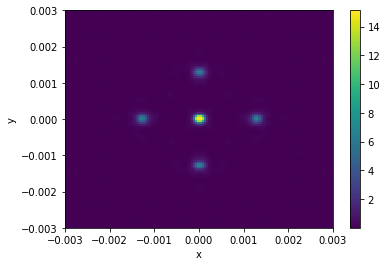

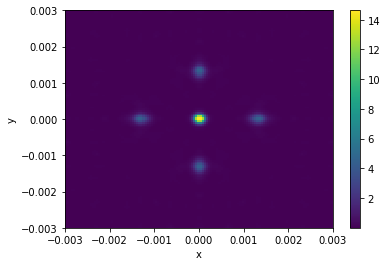

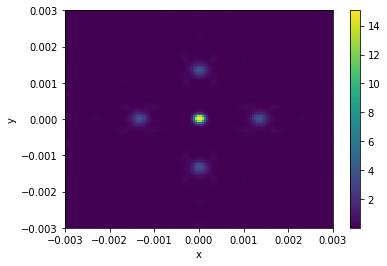

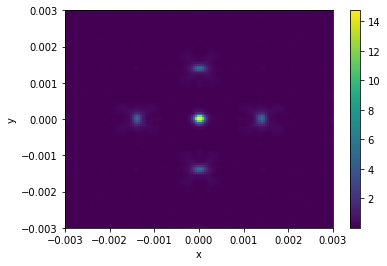

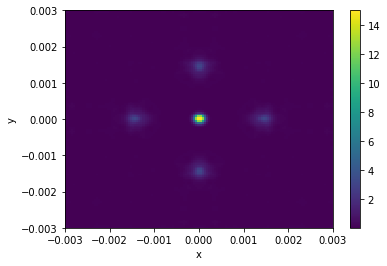

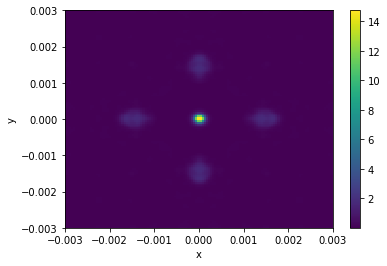

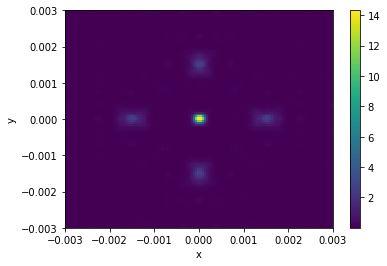

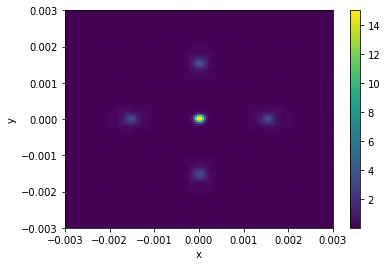

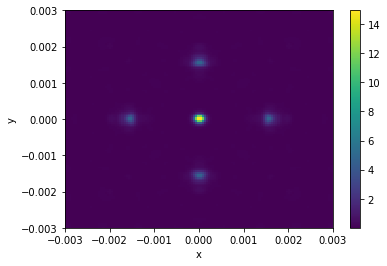

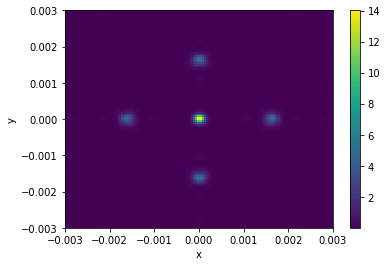

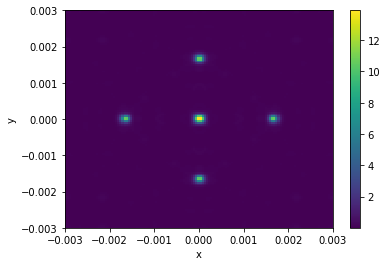

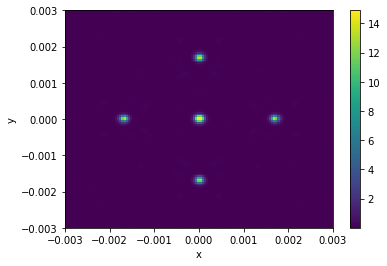

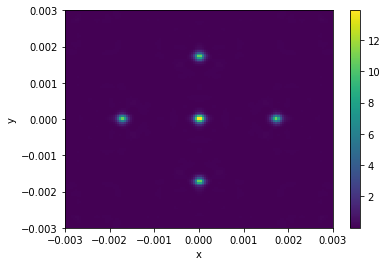

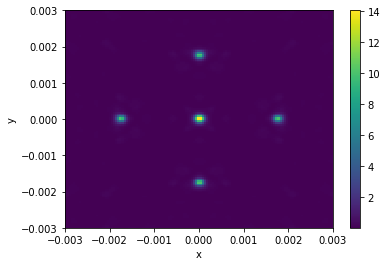

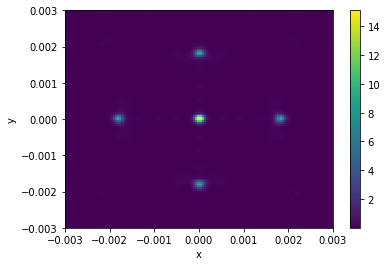

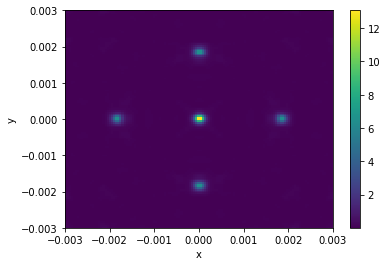

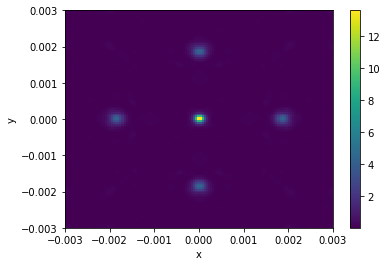

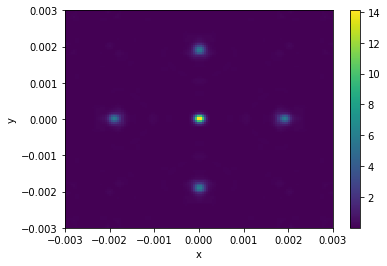

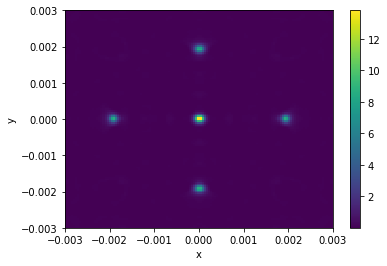

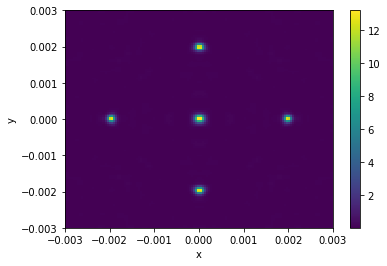

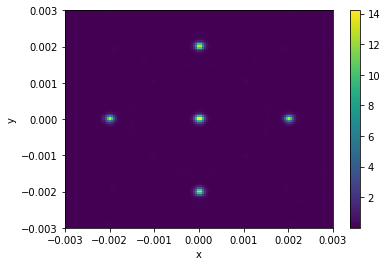

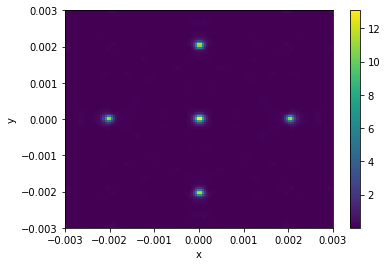

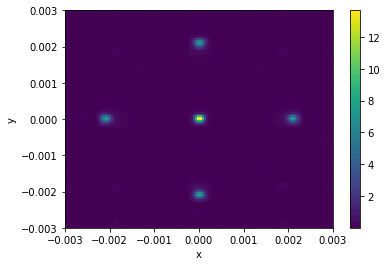

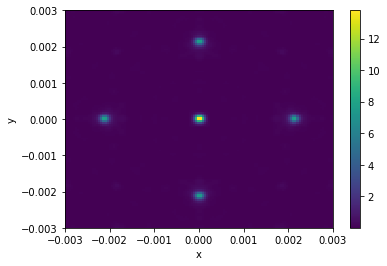

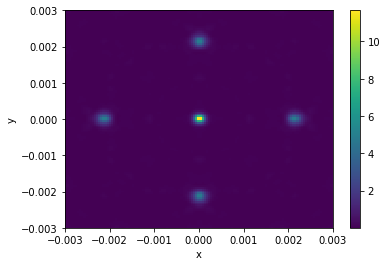

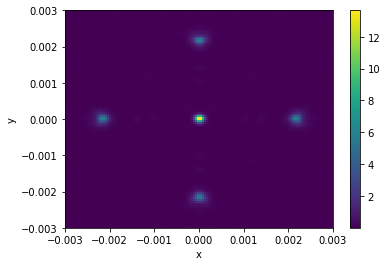

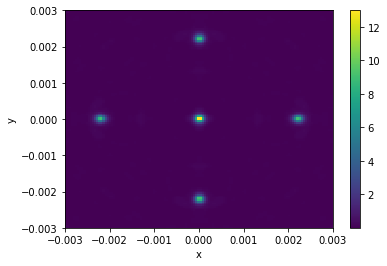

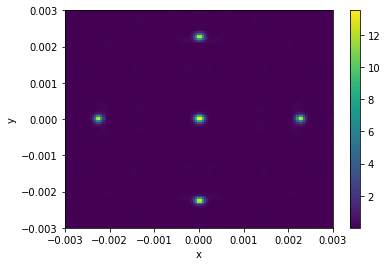

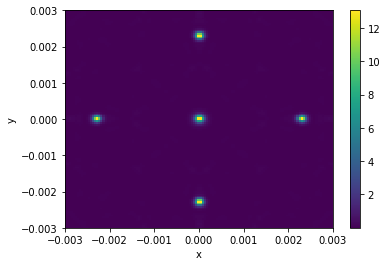

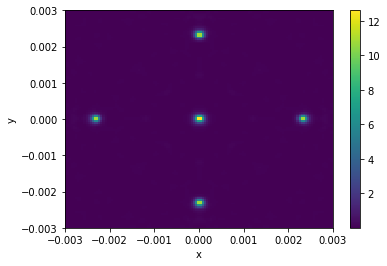

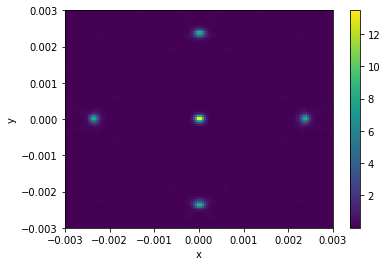

In [9]:
for i in range(laser.matrix.shape[0]):
    if (i % 10 == 0):
        fig, ax = plt.subplots()
        mesh = ax.pcolormesh(laser.x, laser.y, laser.matrix[i])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.colorbar(mesh, ax=ax)
        fig.show()

In [10]:
def f(x, a = 1, b = 2):
    return a*x - b*x**2

In [11]:
print(f(1))
print(f(1, a = 12))
print(f(1, b = 12))

-1
10
-11
